#### FEATURE ENGINEERING
We'll add a few features to the identified 1-on-1 reps. Namely:

1. Join player data (name, position, weight, draft pick, etc.)
2. Identify "contact" events

In [1]:
# Import Libraries

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from pathlib import Path
import ipywidgets as widgets
from ipywidgets import Dropdown, IntSlider, Play, Button, HBox, VBox, Output, jslink
from IPython.display import display, clear_output

%matplotlib widget

#### CELL 1: IMPORT PLAYER DATA AND MISSING NAMES
The following cell imports the given player data, joins selected features onto the filtered reps, and adds on missing names. (There are a few players whose GSIS ID doesn't show up in the player data. In cases where there are no more than two players with the same jersey number, OL and DL's are matched based on their team and jersey number from here: https://shrinebowl.com/wp-content/uploads/2024/07/2024.pdf)

In [2]:
# Load College Player Data
college = pl.read_csv("~/Desktop/ShrineBowlSumerSportsAnalyticsCompetition/player_data/shrine_bowl_players_college_stats.csv").rename({"college_gsis_id": "gsis_id"})

# Load NFL Player Data
nfl = pl.read_csv("~/Desktop/ShrineBowlSumerSportsAnalyticsCompetition/player_data/shrine_bowl_players_nfl_rookie_stats.csv").rename({"college_gsis_id": "gsis_id"})

# Load Shrine Player Data
shrine_players = pl.read_parquet("~/Desktop/ShrineBowlSumerSportsAnalyticsCompetition/player_data/shrine_bowl_players.parquet").with_columns(
    pl.col("gsis_player_id").cast(pl.Int64).alias("gsis_id"),
    pl.col("weight").cast(pl.Float64).alias("college_weight"),
    pl.col("height").cast(pl.Float64).alias("college_height"),
    pl.col("draft_season").cast(pl.Int64).alias("nfl_draft_season"),
    pl.col("draft_round").cast(pl.Int64).alias("nfl_draft_round"),
    pl.col("draft_pick").cast(pl.Int64).alias("nfl_draft_pick"),
    pl.col("draft_overall_selection").cast(pl.Int64).alias("nfl_draft_overall_selection")
).select(["gsis_id", "college_weight", "college_height", "nfl_draft_season", "nfl_draft_round", "nfl_draft_pick", "nfl_draft_overall_selection"])

# Combine College and NFL Data
players = pl.concat([college.unique(subset=['gsis_id'], keep='last'), nfl], how="diagonal").unique("gsis_id")

# Add height, weight and draft information to the players dataframe
players = players.join(shrine_players, on="gsis_id", how="left")

# Select Subset of Relevant Columns
player_df = players.select(["gsis_id", "player_name", "position", "college_weight", "nfl_draft_round", "nfl_draft_pick", "nfl_draft_overall_selection"])

# Load filtered rep data and add player information
df = pl.read_csv("~/Desktop/ShrineBowlSumerSportsAnalyticsCompetition/Output/all_reps_df_filtered.csv")

# Join Player Information Onto Rep Data
df = df.join(
    player_df.select(pl.all().name.prefix("ol_")), # Set OL prefix
    on="ol_gsis_id", # Join OL information specifically
    how="left"
).join(
    player_df.select(pl.all().name.prefix("dl_")), # Set DL prefix 
    on="dl_gsis_id", # Join DL information specifically
    how="left"
)

# Add player add-ons for missing OL/DL names (Note: This CSV was created manually outside of the notebook. Weight is combine weight)
# 2024 East-West Shrine Bowl Rosters, with jersey numbers, can be found publically here: https://shrinebowl.com/wp-content/uploads/2024/07/2024.pdf
player_addons = pl.read_csv("~/Desktop/ShrineBowlSumerSportsAnalyticsCompetition/player_data/player_addons.csv").with_columns([
    pl.col("ol_id").cast(pl.Int64, strict=False),
    pl.col("dl_id").cast(pl.Int64, strict=False),
])

ol_addons = player_addons.filter(pl.col("ol_id").is_not_null()).select([
    pl.col("ol_id").alias("ol_zebra_id"),
    pl.col("player_name").alias("ol_player_name_addon"),
    pl.col("position").alias("ol_position_addon"),
    pl.col("college_weight").alias("ol_college_weight_addon"),
    pl.col("nfl_draft_round").alias("ol_nfl_draft_round_addon"),
    pl.col("nfl_draft_pick").alias("ol_nfl_draft_pick_addon"),
    pl.col("nfl_draft_overall_selection").alias("ol_nfl_draft_overall_selection_addon"),
])

dl_addons = player_addons.filter(pl.col("dl_id").is_not_null()).select([
    pl.col("dl_id").alias("dl_zebra_id"),
    pl.col("player_name").alias("dl_player_name_addon"),
    pl.col("position").alias("dl_position_addon"),
    pl.col("college_weight").alias("dl_college_weight_addon"),
    pl.col("nfl_draft_round").alias("dl_nfl_draft_round_addon"),
    pl.col("nfl_draft_pick").alias("dl_nfl_draft_pick_addon"),
    pl.col("nfl_draft_overall_selection").alias("dl_nfl_draft_overall_selection_addon"),
])

df = df.join(ol_addons, on="ol_zebra_id", how="left").join(dl_addons, on="dl_zebra_id", how="left")

df = df.with_columns([
    (pl.col("ol_player_name").is_null() & pl.col("ol_zebra_id").is_not_null()).alias("ol_needs_fill"),
    (pl.col("dl_player_name").is_null() & pl.col("dl_zebra_id").is_not_null()).alias("dl_needs_fill"),
])

df = df.with_columns([
    pl.when(pl.col("ol_needs_fill")).then(pl.col("ol_player_name_addon")).otherwise(pl.col("ol_player_name")).alias("ol_player_name"),
    pl.when(pl.col("ol_needs_fill")).then(pl.col("ol_position_addon")).otherwise(pl.col("ol_position")).alias("ol_position"),
    pl.when(pl.col("ol_needs_fill")).then(pl.col("ol_college_weight_addon")).otherwise(pl.col("ol_college_weight")).alias("ol_college_weight"),
    pl.when(pl.col("ol_needs_fill")).then(pl.col("ol_nfl_draft_round_addon")).otherwise(pl.col("ol_nfl_draft_round")).alias("ol_nfl_draft_round"),
    pl.when(pl.col("ol_needs_fill")).then(pl.col("ol_nfl_draft_pick_addon")).otherwise(pl.col("ol_nfl_draft_pick")).alias("ol_nfl_draft_pick"),
    pl.when(pl.col("ol_needs_fill")).then(pl.col("ol_nfl_draft_overall_selection_addon")).otherwise(pl.col("ol_nfl_draft_overall_selection")).alias("ol_nfl_draft_overall_selection"),
    pl.when(pl.col("dl_needs_fill")).then(pl.col("dl_player_name_addon")).otherwise(pl.col("dl_player_name")).alias("dl_player_name"),
    pl.when(pl.col("dl_needs_fill")).then(pl.col("dl_position_addon")).otherwise(pl.col("dl_position")).alias("dl_position"),
    pl.when(pl.col("dl_needs_fill")).then(pl.col("dl_college_weight_addon")).otherwise(pl.col("dl_college_weight")).alias("dl_college_weight"),
    pl.when(pl.col("dl_needs_fill")).then(pl.col("dl_nfl_draft_round_addon")).otherwise(pl.col("dl_nfl_draft_round")).alias("dl_nfl_draft_round"),
    pl.when(pl.col("dl_needs_fill")).then(pl.col("dl_nfl_draft_pick_addon")).otherwise(pl.col("dl_nfl_draft_pick")).alias("dl_nfl_draft_pick"),
    pl.when(pl.col("dl_needs_fill")).then(pl.col("dl_nfl_draft_overall_selection_addon")).otherwise(pl.col("dl_nfl_draft_overall_selection")).alias("dl_nfl_draft_overall_selection"),
])

df = df.drop([
    "ol_player_name_addon", "ol_position_addon", "ol_college_weight_addon",
    "ol_nfl_draft_round_addon", "ol_nfl_draft_pick_addon", "ol_nfl_draft_overall_selection_addon",
    "dl_player_name_addon", "dl_position_addon", "dl_college_weight_addon",
    "dl_nfl_draft_round_addon", "dl_nfl_draft_pick_addon", "dl_nfl_draft_overall_selection_addon",
    "ol_needs_fill", "dl_needs_fill",
])

# Impute Mean Weights for Missing Values
df = df.with_columns(
    ol_college_weight = pl.col("ol_college_weight").fill_null(pl.col("ol_college_weight").mean()),
    dl_college_weight = pl.col("dl_college_weight").fill_null(pl.col("dl_college_weight").mean())
)

#### CELL 2: "CONTACT ONSET" DETECTION
The rep detection algorithm already provides the start and end (disengagement) of each rep, but we now face a second segementation challenge: When did the "contact onset" point occur? Identifying the contact onset point is the first step identifying evaluation-style metrics, like closing speed, displacement (a proxy for power), bend, and more. The main challenge here is that there's no film to validate when the contact onset point occurred, so we must infer contact onset based on the available tracking data. (As such, the "contact onset" frame is a proxy for actual the contact onset point.) To do so, we'll go through a two-step process:

1. **Engagement Window Detection**: It anchors on the closest OL–DL approach early in the rep and treats that as a contact proxy. It then walks backward to find when distance first stays under a matchup‑specific threshold and forward to find sustained separation/disengagement. This created rough per-rep lower and upper bounds for the engagement window and is used as a fallback for when contact onset detection identifies a contact onset point too late in the rep.

2. **Contact Onset Point Detection**: It derives kinematic signals (closing speed, jerk, lateral accel) and runs a state machine that gates on proximity and shrinking pairwise distance (closing). It declares contact onset when two of three confirmation signals (closing speed collapse, coupling signature and jerk spike). In the vast majority of cases, closing speed collapse and coupling signature are the primary confirmation signals. A small quality control loop ensures that the contact onset point is never declared too late in the rep.

##### CELL 2A: ENGAGEMENT WINDOW DETECTION

In [4]:
# Add Frame Number Per Rep
df = df.with_columns(
    pl.cum_count("rep_number")
    .over(["session_name", "rep_number"])
    .alias("frame_number")
)

# Minimum Distance Anchored Engagement Window
# Engagement Indicators 
# Flag frames where OL-DL are actively engaged based on:
# 1. Position-based distance threshold (DE= 1.0, DT= 0.85 yards)
# 2. Trend filter: only when closing or stable (not separating)

# Define thresholds by matchup type
EDGE_THRESHOLD = 1.0     # DE (defensive end) matchups - stay farther apart
INTERIOR_THRESHOLD = 0.85 # DT (defensive tackle) matchups - tighter proximity

# Add matchup type and engagement columns
# Impute manual matchups
manual_matchups = {
    "2024WestPractice1": {
        1: "EDGE",
        2: "EDGE",
        3: "INTERIOR",
        4: "INTERIOR",
        5: "INTERIOR",
        6: "INTERIOR",
        7: "INTERIOR",
        8: "INTERIOR",
        9: "EDGE",
        10: "EDGE",
        11: "EDGE",
        12: "EDGE",
        13: "EDGE",
        14: "INTERIOR",
        15: "INTERIOR",
        16: "INTERIOR",
        17: "INTERIOR",
        18: "NONE",
        19: "NONE",
        20: "EDGE",
        21: "EDGE",
        22: "EDGE",
        23: "EDGE",
        24: "INTERIOR",
        25: "INTERIOR",
        26: "INTERIOR",
        27: "INTERIOR",
        28: "INTERIOR",
        29: "INTERIOR",
        30: "EDGE",
        31: "EDGE",
        32: "EDGE",
        33: "EDGE",
    },
    "2024WestPractice2": {
        1: "EDGE",
        2: "EDGE",
        3: "INTERIOR",
        4: "INTERIOR",
        5: "INTERIOR",
        6: "INTERIOR",
        7: "INTERIOR",
        8: "EDGE",
        9: "EDGE",
        10: "EDGE",
        11: "EDGE",
        12: "EDGE",
        13: "INTERIOR",
        14: "INTERIOR",
        15: "INTERIOR",
        16: "INTERIOR",
        17: "INTERIOR",
        18: "INTERIOR",
        19: "EDGE",
        20: "EDGE",
        21: "EDGE",
        22: "EDGE",
        23: "EDGE",
        24: "INTERIOR",
    },
    "2024WestPractice3": {
        1: "EDGE",
        2: "EDGE",
        3: "INTERIOR",
        4: "INTERIOR",
        5: "INTERIOR",
        6: "INTERIOR",
        7: "INTERIOR",
        8: "INTERIOR",
        9: "EDGE",
        10: "EDGE",
        11: "NONE",
        12: "EDGE",
        13: "EDGE",
        14: "INTERIOR",
        15: "INTERIOR",
        16: "INTERIOR",
        17: "EDGE",
        18: "EDGE",
        19: "INTERIOR",
        20: "INTERIOR",
        21: "INTERIOR",
        22: "EDGE",
    },
    "2024EastPractice1": {
        1: "INTERIOR",
        2: "INTERIOR",
        3: "INTERIOR",
        4: "EDGE",
        5: "NONE",
        6: "INTERIOR",
        7: "INTERIOR",
        8: "INTERIOR",
        9: "EDGE",
        10: "NONE",
        11: "EDGE",
        12: "INTERIOR",
        13: "INTERIOR",
        14: "INTERIOR",
        15: "EDGE/FILTER",
        16: "INTERIOR",
        17: "INTERIOR",
        18: "INTERIOR",
        19: "EDGE/FILTER",
    },
    "2024EastPractice2": {
        1: "EDGE",
        2: "INTERIOR",
        3: "INTERIOR",
        4: "INTERIOR",
        5: "EDGE",
        6: "EDGE",
        7: "INTERIOR",
        8: "NONE",
        9: "INTERIOR",
        10: "EDGE",
        11: "EDGE",
        12: "INTERIOR",
        13: "INTERIOR",
        14: "INTERIOR",
        15: "EDGE",
        16: "EDGE",
        17: "INTERIOR",
        18: "NONE/EDGE",
        19: "INTERIOR",
        20: "EDGE",
        21: "NONE",
        22: "NONE",
    },
    "2024EastPractice3": {
        1: "EDGE",
        2: "INTERIOR",
        3: "INTERIOR",
        4: "INTERIOR",
        5: "EDGE",
        6: "EDGE",
        7: "INTERIOR",
        8: "INTERIOR",
        9: "INTERIOR",
        10: "EDGE",
        11: "EDGE",
        12: "INTERIOR",
        13: "INTERIOR",
        14: "EDGE",
    },
}

manual_rows = [
    {"session_name": session, "rep_number": rep_num, "matchup_type": label}
    for session, reps in manual_matchups.items()
    for rep_num, label in reps.items()
]
manual_df = pl.DataFrame(manual_rows)

df = df.join(manual_df, on=["session_name", "rep_number"], how="left")

df = df.with_columns([
    # Matchup type mapping
    pl.when((pl.col("dl_position") == "DE") & (pl.col("ol_position") == "OT"))
      .then(pl.lit("EDGE"))
      .when((pl.col("dl_position") == "DT") & (pl.col("ol_position").is_in(["OG", "OC", "C"])))
      .then(pl.lit("INTERIOR"))
      .otherwise(pl.col("matchup_type"))
      .alias("matchup_type")
])

# Then set the threshold based on that new column
df = df.with_columns([
    pl.when(pl.col("matchup_type") == "EDGE")
      .then(pl.lit(EDGE_THRESHOLD))
      .otherwise(pl.lit(INTERIOR_THRESHOLD))
      .alias("engagement_threshold")
])

# Configuration for collision-anchored window
COLLISION_SEARCH_WINDOW = 30  # Search for min distance within first n frames

# Engagement start thresholds
EDGE_ENGAGE_THRESHOLD = 1.0
INTERIOR_ENGAGE_THRESHOLD = 0.85

# Engagement end parameters
END_DISTANCE_THRESHOLD = 0.6  # Must be >= this distance
END_INCREASE_THRESHOLD = 0.05  # Must increase by at least this much per frame
END_CONSECUTIVE_FRAMES = 3     # Number of consecutive frames required

def compute_collision_anchored_window(rep_df: pl.DataFrame) -> dict:
    """
    Compute collision-anchored engagement window for a single rep.
    
    Collision frame proxy = frame with minimum pairwise_distance in first 30 frames (NOT RELIABLE. DON'T USE.)
    
    Engagement start = Looking backward from minimum distance frame, find first frame where
                       pairwise_distance <= threshold (1.0 EDGE, 0.85 INTERIOR)
                       (The idea is to find a proxy for where engagement begins, after the
                       get-off.)
    
    Engagement end = Looking forward from minimum distance frame, find first of 3 consecutive
                     frames where distance >= 0.5 AND increasing by >= 0.03 each frame
                     (The idea is to find a proxy for disengagement.)
    
    Args:
        rep_df: DataFrame for one rep, sorted by frame_number
        
    Returns:
        dict with collision frame info and window boundaries
    """
    session = rep_df["session_name"][0]
    rep_num = rep_df["rep_number"][0]
    matchup_type = rep_df["matchup_type"][0]
    n_frames = rep_df.height
    
    # Get frame numbers, distances, and distance changes
    frame_numbers = rep_df["frame_number"].to_list()
    distances = rep_df["pairwise_distance"].to_list()
    
    # Compute distance changes (current - previous)
    distance_changes = [None]  # First frame has no change
    for i in range(1, len(distances)):
        if distances[i] is not None and distances[i-1] is not None:
            distance_changes.append(distances[i] - distances[i-1])
        else:
            distance_changes.append(None)
    
    # Determine engagement threshold based on matchup type
    engage_threshold = EDGE_ENGAGE_THRESHOLD if matchup_type == "EDGE" else INTERIOR_ENGAGE_THRESHOLD
    
    # Search within first COLLISION_SEARCH_WINDOW frames for minimum distance
    search_limit = min(COLLISION_SEARCH_WINDOW, n_frames)
    search_distances = distances[:search_limit]
    search_frames = frame_numbers[:search_limit]
    
    # Find minimum distance (handling potential None values)
    valid_pairs = [(i, f, d) for i, (f, d) in enumerate(zip(search_frames, search_distances)) if d is not None]
    
    if not valid_pairs:
        return {
            "session_name": session,
            "rep_number": rep_num,
            "collision_frame": None, # DON'T USE COLLISION FRAMES
            "collision_distance": None,
            "collision_idx": None,
            "window_start": None,
            "window_end": None,
            "window_start_reason": None,
            "window_end_reason": None,
        }
    
    collision_idx, collision_frame, collision_distance = min(valid_pairs, key=lambda x: x[2])
    
    # FIND ENGAGEMENT START: Look backward from collision frame
    # Use the 3rd consecutive under-threshold frame as window_start (more robust than the first).
    window_start = None
    window_start_reason = None

    consecutive_indices = []
    for i in range(collision_idx, -1, -1):  # Go backward from collision
        if distances[i] is not None and distances[i] <= engage_threshold:
            consecutive_indices.append(i)
        else:
            # Distance exceeded threshold, so engagement run ends
            break

    if consecutive_indices:
        run_start_idx = consecutive_indices[-1]  # earliest index in the run
        if len(consecutive_indices) >= 3:
            window_start_idx = run_start_idx + 2
            window_start_reason = f"dist<={engage_threshold} (3rd frame)"
        else:
            window_start_idx = run_start_idx
            window_start_reason = f"dist<={engage_threshold} (short run)"
        window_start = frame_numbers[window_start_idx]
    else:
        window_start = frame_numbers[0]
        window_start_reason = "rep_start"

# FIND ENGAGEMENT END: Look forward from collision frame
    # Find first of 3 consecutive frames where:
    #   - distance >= END_DISTANCE_THRESHOLD (0.6)
    #   - distance is increasing by >= END_INCREASE_THRESHOLD (0.05) each frame
    window_end = None
    window_end_reason = None
    
    for i in range(collision_idx, n_frames - END_CONSECUTIVE_FRAMES + 1):
        # Check if this could be the start of 3 consecutive separation frames
        valid_sequence = True
        
        for j in range(END_CONSECUTIVE_FRAMES):
            idx = i + j
            dist = distances[idx]
            dist_change = distance_changes[idx]
            
            # Check conditions: distance >= 0.5 AND increasing by >= 0.03
            if dist is None or dist_change is None:
                valid_sequence = False
                break
            if dist < END_DISTANCE_THRESHOLD:
                valid_sequence = False
                break
            if dist_change < END_INCREASE_THRESHOLD:
                valid_sequence = False
                break
        
        if valid_sequence:
            # Found the separation sequence - engagement ends at frame i (first of the 3)
            window_end = frame_numbers[i]
            window_end_reason = f"3_consec_sep"
            break
    
    # If no separation sequence found, engagement extends to end of rep
    if window_end is None:
        window_end = frame_numbers[-1]
        window_end_reason = "rep_end"
    
    return {
        "session_name": session,
        "rep_number": rep_num,
        "collision_frame": collision_frame,
        "collision_distance": collision_distance,
        "collision_idx": collision_idx,
        "window_start": window_start,
        "window_end": window_end,
        "window_start_reason": window_start_reason,
        "window_end_reason": window_end_reason,
    }

# Compute collision-anchored windows for all reps
collision_windows = []
for (session, rep_num), rep_group in df.group_by(["session_name", "rep_number"]):
    rep_sorted = rep_group.sort("frame_number")
    window_info = compute_collision_anchored_window(rep_sorted)
    collision_windows.append(window_info)

# Create lookup DataFrame
collision_window_df = pl.DataFrame(collision_windows)

# Join window info back to main DataFrame (drop old columns if they exist)
cols_to_drop = ["collision_frame", "collision_distance", "collision_idx", 
                "window_start", "window_end", "window_start_reason", 
                "window_end_reason", "in_collision_window"]
existing_cols = [c for c in cols_to_drop if c in df.columns]
if existing_cols:
    df = df.drop(existing_cols)

df = df.join(
    collision_window_df,
    on=["session_name", "rep_number"],
    how="left"
)


# Window adjustments (rep_start + rep_end QC)
RECOMPUTE_EDGE_THRESHOLD = 1.2 # Increment by 0.2 yards
RECOMPUTE_INTERIOR_THRESHOLD = 1.05 # Increment by 0.2 yards
SPEED_END_THRESHOLD = 0.5
SPEED_END_MIN_FRAMES = 10  # Minimum frames after window_start before local_speed_min can fire
COLLISION_SEARCH_WINDOW_LOCAL = 30
END_DISTANCE_THRESHOLD_LOCAL = 0.6
END_INCREASE_THRESHOLD_LOCAL = 0.05
END_CONSECUTIVE_FRAMES_LOCAL = 3


def adjust_window_for_rep(rep_df: pl.DataFrame) -> dict:
    session = rep_df["session_name"][0]
    rep_num = rep_df["rep_number"][0]
    matchup_type = rep_df["matchup_type"][0]
    window_start = rep_df["window_start"][0]
    window_end = rep_df["window_end"][0]
    window_start_reason = rep_df["window_start_reason"][0]
    window_end_reason = rep_df["window_end_reason"][0]

    frame_numbers = rep_df["frame_number"].to_list()
    distances = rep_df["pairwise_distance"].to_list()
    ol_s = rep_df["ol_s"].to_list()
    dl_s = rep_df["dl_s"].to_list()

    search_limit = min(COLLISION_SEARCH_WINDOW_LOCAL, len(frame_numbers))
    valid_pairs = [
        (i, f, d)
        for i, (f, d) in enumerate(zip(frame_numbers[:search_limit], distances[:search_limit]))
        if d is not None
    ]
    collision_idx = min(valid_pairs, key=lambda x: x[2])[0] if valid_pairs else None

    # Recompute window only for reps that originally started at rep_start
    if window_start_reason == "rep_start" and collision_idx is not None:
        engage_threshold = (
            RECOMPUTE_EDGE_THRESHOLD
            if matchup_type == "EDGE"
            else RECOMPUTE_INTERIOR_THRESHOLD
        )

        # Use the 3rd consecutive under-threshold frame as window_start (more robust than the first).
        consecutive_indices = []
        for i in range(collision_idx, -1, -1):
            dist = distances[i]
            if dist is not None and dist <= engage_threshold:
                consecutive_indices.append(i)
            else:
                break

        if consecutive_indices:
            run_start_idx = consecutive_indices[-1]
            if len(consecutive_indices) >= 3:
                window_start_idx = run_start_idx + 2
                new_start = frame_numbers[window_start_idx]
                window_start_reason = f"dist<={engage_threshold} (3rd frame)"
            else:
                new_start = frame_numbers[run_start_idx]
                window_start_reason = f"dist<={engage_threshold} (short run)"
        else:
            new_start = frame_numbers[0]
            window_start_reason = "rep_start"

        distance_changes = [None]
        for i in range(1, len(distances)):
            if distances[i] is not None and distances[i - 1] is not None:
                distance_changes.append(distances[i] - distances[i - 1])
            else:
                distance_changes.append(None)

        new_end = None
        window_end_reason = "rep_end"
        for i in range(collision_idx, len(frame_numbers) - END_CONSECUTIVE_FRAMES_LOCAL + 1):
            valid_sequence = True
            for j in range(END_CONSECUTIVE_FRAMES_LOCAL):
                idx = i + j
                dist = distances[idx]
                dist_change = distance_changes[idx]
                if dist is None or dist_change is None:
                    valid_sequence = False
                    break
                if dist < END_DISTANCE_THRESHOLD_LOCAL:
                    valid_sequence = False
                    break
                if dist_change < END_INCREASE_THRESHOLD_LOCAL:
                    valid_sequence = False
                    break

            if valid_sequence:
                new_end = frame_numbers[i]
                window_end_reason = "3_consec_sep"
                break

        if new_end is None:
            new_end = frame_numbers[-1]
            window_end_reason = "rep_end"

        window_start = new_start
        window_end = new_end

    # End-of-rep QC: only for reps that still end at rep_end
    # Only fire local_speed_min if candidate frame is >= window_start + SPEED_END_MIN_FRAMES
    if window_end_reason == "rep_end" and collision_idx is not None:
        speed_end_idx = None
        for i in range(collision_idx, len(frame_numbers)):
            ol_speed = ol_s[i]
            dl_speed = dl_s[i]
            ol_low = ol_speed is not None and not np.isnan(ol_speed) and ol_speed <= SPEED_END_THRESHOLD
            dl_low = dl_speed is not None and not np.isnan(dl_speed) and dl_speed <= SPEED_END_THRESHOLD
            if ol_low or dl_low:
                speed_end_idx = i
                break
        if speed_end_idx is not None and frame_numbers[speed_end_idx] >= window_start + SPEED_END_MIN_FRAMES:
            window_end = frame_numbers[speed_end_idx]
            window_end_reason = "local_speed_min"

    return {
        "session_name": session,
        "rep_number": rep_num,
        "window_start_adj": window_start,
        "window_end_adj": window_end,
        "window_start_reason_adj": window_start_reason,
        "window_end_reason_adj": window_end_reason,
    }


window_adjustments = []
for (session, rep_num), rep_group in df.group_by(["session_name", "rep_number"]):
    rep_sorted = rep_group.sort("frame_number")
    window_adjustments.append(adjust_window_for_rep(rep_sorted))

window_adjustments_df = pl.DataFrame(window_adjustments)

df = df.join(window_adjustments_df, on=["session_name", "rep_number"], how="left")

df = df.with_columns([
    pl.coalesce(pl.col("window_start_adj"), pl.col("window_start")).alias("window_start"),
    pl.coalesce(pl.col("window_end_adj"), pl.col("window_end")).alias("window_end"),
    pl.coalesce(pl.col("window_start_reason_adj"), pl.col("window_start_reason")).alias("window_start_reason"),
    pl.coalesce(pl.col("window_end_reason_adj"), pl.col("window_end_reason")).alias("window_end_reason"),
])

df = df.drop([
    "window_start_adj",
    "window_end_adj",
    "window_start_reason_adj",
    "window_end_reason_adj",
])

# Cap duration to 35 frames
df = df.with_columns(
    pl.when((pl.col("window_end") - pl.col("window_start") + 1) > 35)
    .then(pl.col("window_start") + 35)
    .otherwise(pl.col("window_end"))
    .alias("window_end")
)

# trim 3 seconds for specific case
df = df.with_columns(
    pl.when(((pl.col("window_end") - pl.col("window_start") + 1) > 25) & (pl.col("window_end_reason") == "rep_end"))
    .then(pl.col("window_end") - 3)
    .otherwise(pl.col("window_end"))
    .alias("window_end")
)

# Add column indicating if frame is within engagement-anchored window
df = df.with_columns(
    pl.col("frame_number").is_between(pl.col("window_start"), pl.col("window_end"))
    .alias("engaged")
)

# Add engagement window duration
df = df.with_columns([
    (pl.col("window_end") - pl.col("window_start") + 1).alias("engagement_duration")
])

##### CELL 2B: COLLISION POINT DETECTION (Rules‑based, per‑rep)

  Inputs
  Raw tracking: x, y, s, dir, a/sa, pairwise_distance

  Derived signals

  - v_close = max(0, -(d_t − d_{t-1}) / dt)
  - J_max = max(jerk_ol, jerk_dl) from sa (or a if needed)
  - omega, a_lat from unwrapped heading

  Per‑rep thresholds

  - d_min = min(distance)
  - d_close = d_min + D_CLOSE_OFFSET
  - d_hold  = d_close + D_HOLD_OFFSET
  - J_thr = 95th %ile(J_max)
  - a_lat_thr_ol/dl = 90th %ile(a_lat)

  State machine

  - FREE → CANDIDATE when:
      - distance ≤ d_close, and
      - approach holds: ≥70% of last W_PRE frames closing and median v_close ≥
        0.3
  - Confirmations around t
      - C1 (closing collapse):
        delta_v = median(v_close pre) − median(v_close post)
        pass if delta_v ≥ max(C1_FLOOR, C1_MULT_DEFAULT * v_pre)
      - C2 (coupling hold):
        distance ≤ d_hold for MIN_CONSECUTIVE_PROX frames
        and v_close suppressed for MIN_SUPPRESSED_FRAMES
      - C3 (impact spike):
        any J_max ≥ J_thr in [t-1, t+W_CONF]
  - COD reject:
    if C3 true but C1/C2 false, and high lateral accel while not at d_min

  Collision decision

  - collision = (C1 + C2 + C3) ≥ 2 and not COD‑rejected

  Window start override

  - compute window_start_v2 from sustained proximity
  - if no collision → use window_start
  - if collision is much later than window_start → override

  Outputs

  - collision_frame
  - diagnostics: d_min, d_close, v_pre/v_post, reasons

In [7]:
# =============================================================================
# Inspired by:
# - Hendricks et al. (JSSM 2014): 0.5s pre-contact window, "one system" post-contact:
# - https://www.jssm.org/volume13/iss3/cap/jssm-13-557.pdf
# - Hulin et al. (JSAMS 2016): Multi-confirmation, COD rejection, filter short/low-intensity
# - https://pubmed.ncbi.nlm.nih.gov/28153609/
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

# Contact Onset detection parameters (rules-based)
D_CLOSE_OFFSET = 0.25
D_HOLD_OFFSET = 0.06
ALPHA_DEFAULT = 0.2
C1_FLOOR_DEFAULT = 0.15
C1_MULT_DEFAULT = 0.35

W_PRE = 6
W_CONF = 2
MIN_CONSECUTIVE_PROX = 2
MIN_SUPPRESSED_FRAMES_DEFAULT = 1

WINDOW_START_THRESHOLD = 0.85
WINDOW_OVERRIDE_LAG = 3
EARLY_CONTACT_MAX_IDX = 4
EARLY_CONTACT_RISE = 0.12


def _is_nan(value):
    return value is not None and isinstance(value, float) and np.isnan(value)


def _safe(value):
    return 0.0 if value is None or _is_nan(value) else value


def unwrap_angles(angles):
    # Unwrap angle sequence to avoid discontinuities.
    result = [angles[0] if angles[0] is not None and not _is_nan(angles[0]) else 0.0]
    for i in range(1, len(angles)):
        curr = angles[i] if angles[i] is not None and not _is_nan(angles[i]) else result[-1]
        prev = result[-1]
        diff = curr - prev
        if diff > 180:
            curr -= 360
        elif diff < -180:
            curr += 360
        result.append(curr)
    return result


# STEP 1: Compute Derived Kinematics

def compute_contact_onset_kinematics(rep_df: pl.DataFrame) -> pl.DataFrame:
    # Add derived kinematic columns needed for contact_onset detection.
    n = rep_df.height

    ol_s = rep_df["ol_s"].to_list()
    dl_s = rep_df["dl_s"].to_list()
    ol_dir = rep_df["ol_dir"].to_list()
    dl_dir = rep_df["dl_dir"].to_list()
    ol_sa = rep_df["ol_sa"].to_list() if "ol_sa" in rep_df.columns else [0.0] * n
    dl_sa = rep_df["dl_sa"].to_list() if "dl_sa" in rep_df.columns else [0.0] * n
    ol_a = rep_df["ol_a"].to_list() if "ol_a" in rep_df.columns else [0.0] * n
    dl_a = rep_df["dl_a"].to_list() if "dl_a" in rep_df.columns else [0.0] * n
    distances = rep_df["pairwise_distance"].to_list()

    # Velocity vectors (dir=0 points in +x direction)
    ol_vx, ol_vy, dl_vx, dl_vy = [], [], [], []
    for i in range(n):
        ol_theta = np.radians(ol_dir[i]) if ol_dir[i] is not None and not _is_nan(ol_dir[i]) else 0.0
        dl_theta = np.radians(dl_dir[i]) if dl_dir[i] is not None and not _is_nan(dl_dir[i]) else 0.0
        ol_spd = _safe(ol_s[i])
        dl_spd = _safe(dl_s[i])
        ol_vx.append(ol_spd * np.cos(ol_theta))
        ol_vy.append(ol_spd * np.sin(ol_theta))
        dl_vx.append(dl_spd * np.cos(dl_theta))
        dl_vy.append(dl_spd * np.sin(dl_theta))

    # Distance rate and closing speed
    d_dot = [0.0]
    v_close = [0.0]
    for i in range(1, n):
        d_curr = distances[i]
        d_prev = distances[i - 1]
        if d_curr is None or d_prev is None or _is_nan(d_curr) or _is_nan(d_prev):
            d_dot.append(0.0)
            v_close.append(0.0)
        else:
            rate = (d_curr - d_prev) / 0.1
            d_dot.append(rate)
            v_close.append(max(0.0, -rate))

    # Jerk proxies
    J_sa_ol = [0.0]
    J_sa_dl = [0.0]
    J_a_ol = [0.0]
    J_a_dl = [0.0]
    for i in range(1, n):
        sa_ol_curr = _safe(ol_sa[i])
        sa_ol_prev = _safe(ol_sa[i - 1])
        sa_dl_curr = _safe(dl_sa[i])
        sa_dl_prev = _safe(dl_sa[i - 1])
        J_sa_ol.append(abs(sa_ol_curr - sa_ol_prev) / 0.1)
        J_sa_dl.append(abs(sa_dl_curr - sa_dl_prev) / 0.1)

        a_ol_curr = _safe(ol_a[i])
        a_ol_prev = _safe(ol_a[i - 1])
        a_dl_curr = _safe(dl_a[i])
        a_dl_prev = _safe(dl_a[i - 1])
        J_a_ol.append(abs(a_ol_curr - a_ol_prev) / 0.1)
        J_a_dl.append(abs(a_dl_curr - a_dl_prev) / 0.1)

    valid_sa = [v for v in ol_sa + dl_sa if v is not None and not _is_nan(v)]
    sa_variance = np.var(valid_sa) if len(valid_sa) > 2 else 0.0
    if sa_variance > 0.01:
        J_max = [max(J_sa_ol[i], J_sa_dl[i]) for i in range(n)]
        jerk_source = "sa"
    else:
        J_max = [max(J_a_ol[i], J_a_dl[i]) for i in range(n)]
        jerk_source = "a_fallback"

    # COD indicator (heading rate and lateral acceleration proxy)
    ol_dir_unwrap = unwrap_angles(ol_dir)
    dl_dir_unwrap = unwrap_angles(dl_dir)

    omega_ol = [0.0]
    omega_dl = [0.0]
    a_lat_ol = [0.0]
    a_lat_dl = [0.0]

    for i in range(1, n):
        omega_ol_val = (ol_dir_unwrap[i] - ol_dir_unwrap[i - 1]) / 0.1
        omega_dl_val = (dl_dir_unwrap[i] - dl_dir_unwrap[i - 1]) / 0.1
        omega_ol.append(omega_ol_val)
        omega_dl.append(omega_dl_val)

        ol_spd = _safe(ol_s[i])
        dl_spd = _safe(dl_s[i])
        a_lat_ol.append(ol_spd * abs(np.radians(omega_ol_val)))
        a_lat_dl.append(dl_spd * abs(np.radians(omega_dl_val)))

    rep_df = rep_df.with_columns([
        pl.Series("ol_vx", ol_vx),
        pl.Series("ol_vy", ol_vy),
        pl.Series("dl_vx", dl_vx),
        pl.Series("dl_vy", dl_vy),
        pl.Series("d_dot", d_dot),
        pl.Series("v_close", v_close),
        pl.Series("J_sa_ol", J_sa_ol),
        pl.Series("J_sa_dl", J_sa_dl),
        pl.Series("J_a_ol", J_a_ol),
        pl.Series("J_a_dl", J_a_dl),
        pl.Series("J_max", J_max),
        pl.Series("omega_ol", omega_ol),
        pl.Series("omega_dl", omega_dl),
        pl.Series("a_lat_ol", a_lat_ol),
        pl.Series("a_lat_dl", a_lat_dl),
    ])

    return rep_df, jerk_source


def compute_window_start_v2(frame_numbers, distances):
    search_limit = min(30, len(distances))
    dist_arr = np.array([
        d if d is not None and not _is_nan(d) else np.nan for d in distances
    ])
    if np.isnan(dist_arr).all():
        return None

    valid_pairs = [
        (i, dist_arr[i]) for i in range(search_limit) if np.isfinite(dist_arr[i])
    ]
    if not valid_pairs:
        return None

    contact_idx = min(valid_pairs, key=lambda x: x[1])[0]
    if contact_idx <= EARLY_CONTACT_MAX_IDX and search_limit >= 12:
        contact_dist = dist_arr[contact_idx]
        post_median = np.nanmedian(dist_arr[7:12])
        if np.isfinite(post_median) and post_median > contact_dist + EARLY_CONTACT_RISE:
            later_window = dist_arr[8:search_limit]
            if np.isfinite(later_window).any():
                contact_idx = int(np.nanargmin(later_window)) + 8

    consecutive = []
    for i in range(contact_idx, -1, -1):
        if np.isfinite(dist_arr[i]) and dist_arr[i] <= WINDOW_START_THRESHOLD:
            consecutive.append(i)
        else:
            break
    if not consecutive:
        return None

    run_start_idx = consecutive[-1]
    if len(consecutive) >= 3:
        window_start_idx = run_start_idx + 2
    else:
        window_start_idx = run_start_idx

    return {
        "window_start_frame": frame_numbers[window_start_idx],
        "window_start_idx": window_start_idx,
    }


# STEP 2: Contact Onset Detection State Machine (v2)

def detect_contact_onset(rep_df: pl.DataFrame, verbose: bool = False, alpha_override=None, c1_floor_override=None, min_suppressed_override=None) -> dict:
    session = rep_df["session_name"][0]
    rep_num = rep_df["rep_number"][0]
    matchup_type = rep_df["matchup_type"][0] if "matchup_type" in rep_df.columns else "UNKNOWN"

    rep_df, jerk_source = compute_contact_onset_kinematics(rep_df)

    n = rep_df.height
    if n < 8:
        return {
            "session_name": session,
            "rep_number": rep_num,
            "contact_onset_frame": None,
            "contact_onset_detected": False,
            "reason": "insufficient_frames",
        }

    frame_numbers = rep_df["frame_number"].to_list()
    distances = rep_df["pairwise_distance"].to_list()
    v_close = rep_df["v_close"].to_list()
    d_dot = rep_df["d_dot"].to_list()
    J_max = rep_df["J_max"].to_list()
    a_lat_ol = rep_df["a_lat_ol"].to_list()
    a_lat_dl = rep_df["a_lat_dl"].to_list()

    early_window = distances[:min(25, len(distances))]
    valid_distances = [d for d in early_window if d is not None and not _is_nan(d)]
    if not valid_distances:
        valid_distances = [d for d in distances if d is not None and not _is_nan(d)]
    if not valid_distances:
        return {
            "session_name": session,
            "rep_number": rep_num,
            "contact_onset_frame": None,
            "contact_onset_detected": False,
            "reason": "no_valid_distances",
        }

    d_min = min(valid_distances)
    d_close = d_min + D_CLOSE_OFFSET
    d_hold = d_close + D_HOLD_OFFSET

    valid_jerk = [j for j in J_max if j is not None and not _is_nan(j) and j > 0]
    J_thr = np.percentile(valid_jerk, 95) if valid_jerk else 10.0

    valid_a_lat_ol = [a for a in a_lat_ol if a is not None and not _is_nan(a)]
    valid_a_lat_dl = [a for a in a_lat_dl if a is not None and not _is_nan(a)]
    a_lat_thr_ol = np.percentile(valid_a_lat_ol, 90) if valid_a_lat_ol else 1.0
    a_lat_thr_dl = np.percentile(valid_a_lat_dl, 90) if valid_a_lat_dl else 1.0

    ALPHA = ALPHA_DEFAULT if alpha_override is None else alpha_override
    C1_FLOOR = C1_FLOOR_DEFAULT if c1_floor_override is None else c1_floor_override
    MIN_SUPPRESSED_FRAMES = (
        MIN_SUPPRESSED_FRAMES_DEFAULT if min_suppressed_override is None else min_suppressed_override
    )

    state = "FREE"
    contact_onset = None
    confirmations_fired = []
    found_by = None

    last_v_pre = None
    last_v_post = None
    last_delta_v = None

    for t in range(W_PRE, n - 3):
        d_t = distances[t]
        if d_t is None or _is_nan(d_t):
            continue

        if state == "FREE":
            if d_t > d_close:
                continue

            pre_window = d_dot[t - W_PRE : t]
            pre_v_close = v_close[t - W_PRE : t]
            closing_frames = sum(1 for dd in pre_window if dd is not None and dd < 0)
            frac_closing = closing_frames / W_PRE
            valid_pre_v = [v for v in pre_v_close if v is not None]
            median_v_close = np.median(valid_pre_v) if valid_pre_v else 0

            if frac_closing >= 0.7 and median_v_close >= 0.3:
                state = "CANDIDATE"

        if state == "CANDIDATE":
            recent_pre_v = v_close[max(0, t - W_PRE) : t]
            valid_recent_v = [v for v in recent_pre_v if v is not None]
            v_close_baseline = np.median(valid_recent_v) if valid_recent_v else 0.5

            v_pre_window = v_close[max(0, t - 2) : t]
            v_post_window = v_close[t : min(n, t + W_CONF + 1)]
            v_pre = np.median([v for v in v_pre_window if v is not None]) if v_pre_window else 0
            v_post = np.median([v for v in v_post_window if v is not None]) if v_post_window else 0
            delta_v = v_pre - v_post
            C1_threshold = max(C1_FLOOR, C1_MULT_DEFAULT * v_pre)
            C1 = delta_v >= C1_threshold

            proximity_window = distances[t : min(n, t + 4)]
            consecutive_prox = 0
            max_consecutive_prox = 0
            for d in proximity_window:
                if d is not None and not _is_nan(d) and d <= d_hold:
                    consecutive_prox += 1
                    max_consecutive_prox = max(max_consecutive_prox, consecutive_prox)
                else:
                    consecutive_prox = 0

            suppression_window = v_close[t : min(n, t + 3)]
            suppressed_frames = sum(
                1 for v in suppression_window if v is not None and v <= ALPHA * v_close_baseline
            )
            suppressed_sustained = suppressed_frames >= MIN_SUPPRESSED_FRAMES
            C2 = (max_consecutive_prox >= MIN_CONSECUTIVE_PROX) and suppressed_sustained

            spike_window = J_max[max(0, t - 1) : min(n, t + W_CONF + 1)]
            C3 = any(j >= J_thr for j in spike_window if j is not None)

            cod_window_ol = a_lat_ol[t : min(n, t + W_CONF + 1)]
            cod_window_dl = a_lat_dl[t : min(n, t + W_CONF + 1)]
            high_cod_ol = any(a > a_lat_thr_ol for a in cod_window_ol if a is not None)
            high_cod_dl = any(a > a_lat_thr_dl for a in cod_window_dl if a is not None)
            not_at_min = d_t > d_min + 0.15
            cod_reject = C3 and not C1 and not C2 and (high_cod_ol or high_cod_dl) and not_at_min

            confirmations = sum([C1, C2, C3])
            if confirmations >= 2 and not cod_reject:
                contact_onset = t
                found_by = "state_machine"
                confirmations_fired = []
                if C1:
                    confirmations_fired.append("C1_closing_collapse")
                if C2:
                    confirmations_fired.append("C2_coupling")
                if C3:
                    confirmations_fired.append("C3_jerk_spike")
                last_v_pre = v_pre
                last_v_post = v_post
                last_delta_v = delta_v
                break

            if verbose:
                print(
                    f"  Frame {frame_numbers[t]}: C1={C1}(Δv={delta_v:.2f}), C2={C2}(consec={max_consecutive_prox}), "
                    f"C3={C3}, COD_reject={cod_reject}"
                )

            if d_t > d_close * 1.5:
                state = "FREE"

    window_info = compute_window_start_v2(frame_numbers, distances)
    if window_info is not None:
        window_frame = window_info["window_start_frame"]
        window_idx = window_info["window_start_idx"]
        if contact_onset is None:
            contact_onset = window_idx
            found_by = "window_start_fallback"
            confirmations_fired = ["window_start_fallback"]
        elif (frame_numbers[contact_onset] - window_frame) > WINDOW_OVERRIDE_LAG and window_frame > 10:
            contact_onset = window_idx
            found_by = "window_start_override"
            confirmations_fired = ["window_start_override"]
    else:
        window_frame = None
        window_idx = None

    if contact_onset is None:
        return {
            "session_name": session,
            "rep_number": rep_num,
            "contact_onset_detected": False,
            "contact_onset_frame": None,
            "contact_onset_idx": None,
            "d_at_contact_onset": None,
            "d_min": d_min,
            "d_close": d_close,
            "v_close_pre": None,
            "v_close_post": None,
            "intensity_closing_drop": None,
            "intensity_jerk_max": None,
            "confirmations_fired": [],
            "J_thr": J_thr,
            "jerk_source": jerk_source,
            "matchup_type": matchup_type,
            "reason": "no_contact_onset_detected",
            "window_start_v2": window_frame,
            "window_start_idx_v2": window_idx,
            "contact_onset_origin": found_by,
        }

    v_pre = last_v_pre
    v_post = last_v_post
    delta_v = last_delta_v
    if v_pre is None or v_post is None:
        v_pre_window = v_close[max(0, contact_onset - 2) : contact_onset]
        v_post_window = v_close[contact_onset : min(n, contact_onset + W_CONF + 1)]
        v_pre = np.median([v for v in v_pre_window if v is not None]) if v_pre_window else 0
        v_post = np.median([v for v in v_post_window if v is not None]) if v_post_window else 0
        delta_v = v_pre - v_post

    return {
        "session_name": session,
        "rep_number": rep_num,
        "contact_onset_detected": True,
        "contact_onset_frame": frame_numbers[contact_onset],
        "contact_onset_idx": contact_onset,
        "d_at_contact_onset": distances[contact_onset],
        "d_min": d_min,
        "d_close": d_close,
        "v_close_pre": v_pre,
        "v_close_post": v_post,
        "intensity_closing_drop": delta_v,
        "intensity_jerk_max": max(J_max[max(0, contact_onset - 1) : min(n, contact_onset + 3)]) if J_max else None,
        "confirmations_fired": confirmations_fired,
        "J_thr": J_thr,
        "jerk_source": jerk_source,
        "matchup_type": matchup_type,
        "reason": found_by,
        "window_start_v2": window_frame,
        "window_start_idx_v2": window_idx,
        "contact_onset_origin": found_by,
    }


# STEP 3: Apply to all reps

print("Detecting contact onset for all reps (v2)...")
print("V2: state machine + window-start fallback/override")
print()
contact_onset_results = []

for (session, rep_num), rep_group in df.group_by(["session_name", "rep_number"]):
    rep_sorted = rep_group.sort("frame_number")
    result = detect_contact_onset(rep_sorted, verbose=False)
    contact_onset_results.append(result)

contact_onset_df = pl.DataFrame(contact_onset_results)

# =============================================================================
# STEP 4: VALIDATION - Compare contact onset detection with existing engagement windows
# =============================================================================

# Join contact onset results back to main dataframe for comparison

df_with_contact_onset = df.join(
    contact_onset_df.select([
        "session_name", "rep_number", "contact_onset_detected", "contact_onset_frame",
        "contact_onset_idx", "d_at_contact_onset", "intensity_closing_drop", "confirmations_fired",
        "jerk_source"
    ]),
    on=["session_name", "rep_number"],
    how="left"
)

# Get one row per rep for comparison
rep_summary = df_with_contact_onset.unique(["session_name", "rep_number"]).select([
    "session_name", "rep_number", "matchup_type",
    "window_start", "window_end", "collision_frame", "collision_idx",
    "contact_onset_detected", "contact_onset_frame", "contact_onset_idx",
    "d_at_contact_onset", "intensity_closing_drop", "jerk_source"
])

# Filter to detected contact onset for comparison

detected_reps = rep_summary.filter(pl.col("contact_onset_detected") == True)

df = df.join(detected_reps.select(["session_name", "rep_number", "contact_onset_frame"]), on = ["session_name", "rep_number"], how="left")

df = df.with_columns(
    contact_onset_frame = pl.when(
        ((pl.col("contact_onset_frame") - pl.col("window_start")) > 5) & 
        (pl.col("window_start") > 10) &
        (pl.col("contact_onset_frame") > 20)
    )
    .then(pl.col("window_start"))
    .otherwise(pl.col("contact_onset_frame"))
)

df.write_csv("~/Desktop/ShrineBowlSumerSportsAnalyticsCompetition/Output/df_with_features.csv")


Detecting contact onset for all reps (v2)...
V2: state machine + window-start fallback/override



##### CELL 2C: APPROXIMATE VALIDATION
The gold standard for ground truth is validating the contact onset frame with the matching frame in the video. Since this is not possible, the next best approach with the available data is to manually infer the contact onset frame via carefully inspecting each rep. The following heuristics were used to identify a contact onset frame:

1. Is the DL within a minimum distance threshold (<= 1 yard) of the OL?
2. Is pairwise distance shrinking fast?
3. Is the OL-DL near a local minimum in pairwise distance?
4. Does the OL-DL pair act as one "body" (in terms of movement) near the contact onset frame? (More instructive for interior linemen compared to defensive ends and tackles.)

A couple of caveats:
1. The heuristics are not perfect but attempt to capture the essence of what these reps look like on film.
2. The heuristics are not wholly independent from the algorithmic approach used to identify the contact onset frame, since the algorithmic approach uses many of the same heuristics in spirit. Ground truth for when contact onset actually occurred is not known, so the contact onset frame should be treated as a proxy or an estimate.

With that being said, we can compare the differences between the manually identified contact onset frame with the algorithmically identified contact onset frame as a sanity check:



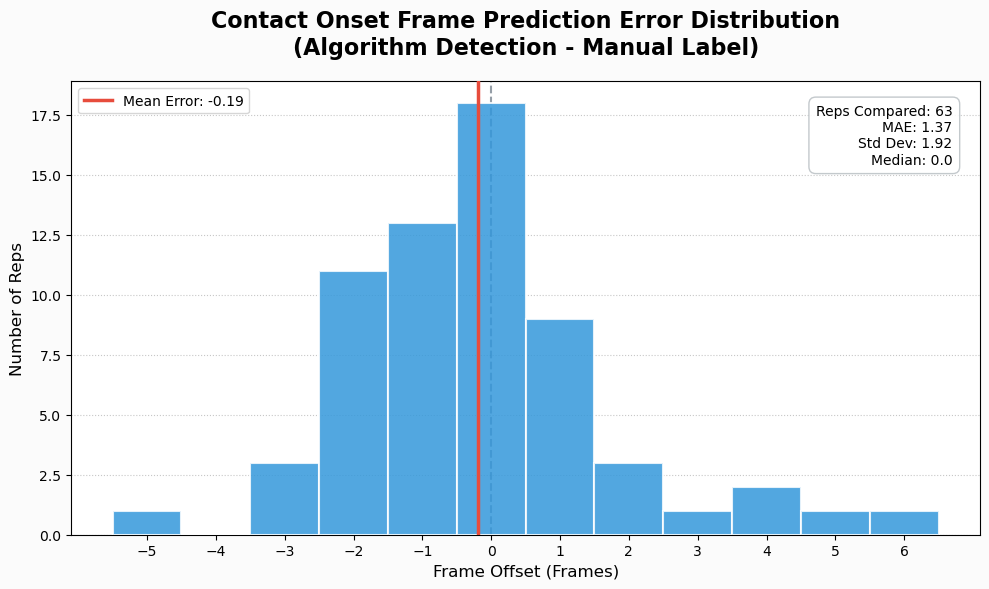

Reps with <= 2 frame error:
85.71428571428571%


In [11]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

contact_onset_df_validation = df.filter(pl.col("matchup_type") == "INTERIOR").select(["session_name", "rep_number", "contact_onset_frame"]).unique().sort(["session_name", "rep_number"])

# 1. Prepare the comparison dataset
contact_onset_df_validation = contact_onset_df_validation.select(["session_name", "rep_number", "contact_onset_frame"]).unique().sort(["session_name", "rep_number"])

# Join manual labels with automatic predictions
# We use .drop_nulls("contact_onset_frame") to focus on reps that have a manual label
comparison_df = (
    pl.read_csv("~/Desktop/ShrineBowlSumerSportsAnalyticsCompetition/ManualTrackingValidation/manual_contact_onset_frame_tracking.csv")
    .join(contact_onset_df_validation, on=["session_name", "rep_number"])
    .with_columns(diff = pl.col("contact_onset_frame") - pl.col("contact_onset_frame_manual"))
    .drop_nulls("diff")
)

# 2. Plotting the results
plt.figure(figsize=(10, 6), facecolor='#fbfbfb')

# Calculate dynamic bins to center bars on integers
diff_data = comparison_df["diff"].to_list()
bins = np.arange(min(diff_data) - 0.5, max(diff_data) + 1.5, 1)

# Plot histogram
plt.hist(
    diff_data, 
    bins=bins, 
    color='#3498db', 
    edgecolor='white', 
    linewidth=1.5,
    alpha=0.85,
    zorder=3
)

# Add Mean line and Zero reference
mean_err = comparison_df["diff"].mean()
plt.axvline(mean_err, color='#e74c3c', linestyle='-', linewidth=2.5, label=f'Mean Error: {mean_err:.2f}', zorder=4)
plt.axvline(0, color='#2c3e50', linestyle='--', linewidth=1.5, alpha=0.5, zorder=2)

# Aesthetics and Labels
plt.title("Contact Onset Frame Prediction Error Distribution\n(Algorithm Detection - Manual Label)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Frame Offset (Frames)", fontsize=12)
plt.ylabel("Number of Reps", fontsize=12)
plt.xticks(np.arange(min(diff_data), max(diff_data) + 1, 1))
plt.grid(axis='y', linestyle=':', alpha=0.7, zorder=0)

# Add Stats Box
stats_text = (
    f"Reps Compared: {len(comparison_df)}\n"
    f"MAE: {comparison_df['diff'].abs().mean():.2f}\n"
    f"Std Dev: {comparison_df['diff'].std():.2f}\n"
    f"Median: {comparison_df['diff'].median()}"
)
plt.text(0.97, 0.95, stats_text, transform=plt.gca().transAxes, verticalalignment='top', 
         horizontalalignment='right', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
         alpha=0.9, edgecolor='#bdc3c7'), fontsize=10, zorder=5)

plt.legend(loc='upper left', frameon=True, facecolor='white')
plt.tight_layout()
plt.show()

# Optional: Print out the reps with particularly large errors for debugging
print("Reps with <= 2 frame error:")
print(f"{((comparison_df.filter(pl.col("diff").abs() <= 2).height)/63)*100}%")

About 85% of the detected collision frames are within two frames of the manually labeled frames.